## Header

In [2]:
import sys
sys.path.append("/Users/cassswagner/Library/CloudStorage/OneDrive-OregonStateUniversity/oceans-research/analysis_scripts/")
# sys.path.append("/Users/cassswagner/Library/CloudStorage/OneDrive-OregonStateUniversity/oceans_sf")
# import oceans_sf as ocsf

In [3]:
from scipy.io import loadmat
from scipy.stats import bootstrap
import traceback
import pandas as pd
import numpy as np
import h5py
import oceans_sf as ocsf
import collections
from calculate_spectral_fluxes import SpectralFlux
from calculate_sfs import StructureFunctions
from flux_sf_figures import *
import flux_sf_figures
from matplotlib import pyplot as plt
import time
import xarray as xr
import cartopy.crs as ccrs

import seaborn as sns
sns.set_style(style='white')
sns.set_context('talk')

plt.rcParams['figure.figsize'] = [9,6]
# plt.rcParams['figure.dpi'] = 100
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
# %config InlineBackend.figure_format = 'svg'

import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

from geopy import distance as gd

import warnings
warnings.filterwarnings("ignore")

In [4]:
import importlib
# import sys
if 'flux_sf_figures' not in sys.modules:
    import flux_sf_figures
    from flux_sf_figures import *
            # import module on first run 
else:                      
    import flux_sf_figures
    from flux_sf_figures import *      
    importlib.reload(flux_sf_figures)

if 'calculate_sfs' not in sys.modules:
    import calculate_sfs            # import module on first run 
else:                      
    import calculate_sfs      
    importlib.reload(calculate_sfs)

if 'ocsf' not in sys.modules:
    import oceans_sf as ocsf            # import module on first run 
else:                      
    import oceans_sf as ocsf      
    importlib.reload(ocsf)

In [5]:
filename = '~/Library/CloudStorage/Box-Box/Observational_Data_for_Cassidy/SWOT/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_001_20111113T000000_20111113T005126_DG10_01.nc'
files = '~/Library/CloudStorage/Box-Box/Observational_Data_for_Cassidy/SWOT/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1/*.nc'

In [6]:
import glob
filelist = glob.glob('/Users/cassswagner/Library/CloudStorage/Box-Box/Observational_Data_for_Cassidy/SWOT/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1/*.nc')

ds_dict = {}

for f in filelist:
    key = os.path.basename(f)
    ds_dict[key] = xr.open_dataset(f)

In [7]:
ds_pacific = ds_dict[os.path.basename(filelist[24])]
ds_pacific.simulated_true_ssh_karin.attrs["units"] = 'cm'

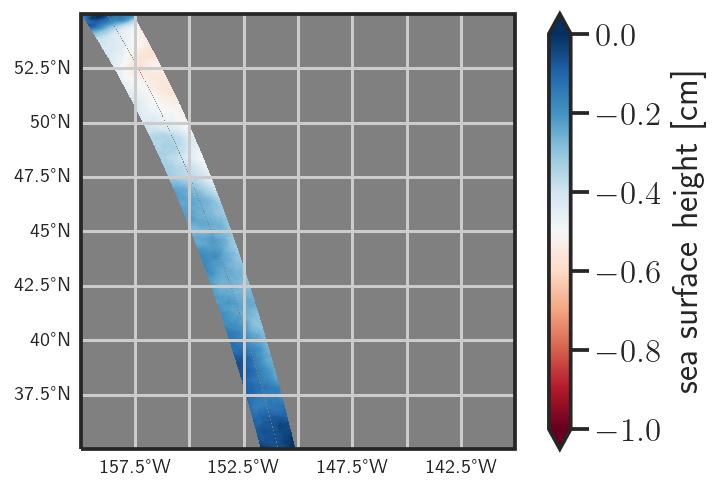

In [8]:
%matplotlib inline

p = ds_pacific.simulated_true_ssh_karin.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu',vmin=-1,vmax=0
)
p.axes.set_global()
p.axes.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
p.axes.set_extent([-160,-140,35,55])

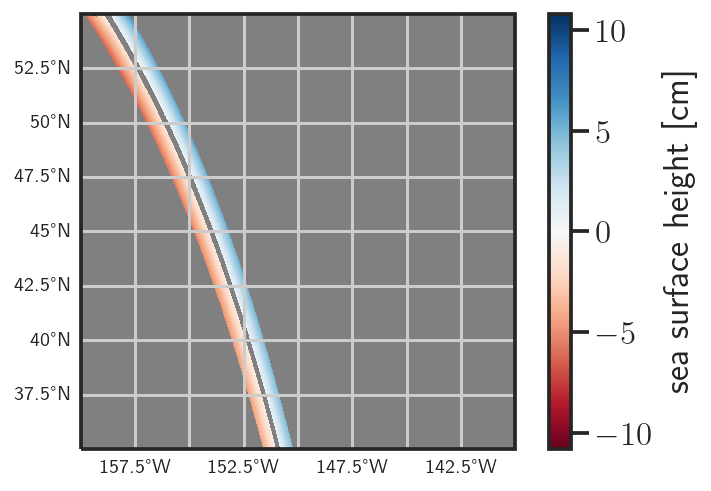

In [9]:
%matplotlib inline
ds_pacific.ssh_karin.attrs["units"] = 'cm'
p = ds_pacific.ssh_karin.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu',
)
p.axes.set_global()
p.axes.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
p.axes.set_extent([-160,-140,35,55])

In [10]:
da_ssh_true_pacific = ds_pacific.simulated_true_ssh_karin.where((ds_pacific.latitude>40) & (ds_pacific.latitude<50),drop=True)

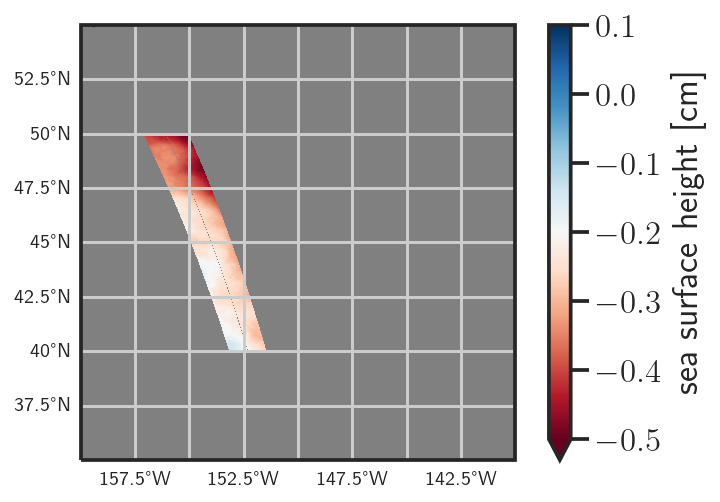

In [11]:
%matplotlib inline

p = da_ssh_true_pacific.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),vmin=-0.5,vmax=0.1,cmap='RdBu'
)
p.axes.set_global()
p.axes.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
p.axes.set_extent([-160,-140,35,55])

In [ ]:
lat_roll_dx = np.roll(da_ssh_true_pacific.latitude.T,shift=-1,axis=0)
lon_roll_dx = np.roll(da_ssh_true_pacific.longitude.T,shift=-1,axis=0)

lat_roll_dy = np.roll(da_ssh_true_pacific.latitude.T,shift=-1,axis=1)
lon_roll_dy = np.roll(da_ssh_true_pacific.longitude.T,shift=-1,axis=1)

stacked_roll_dx = np.stack((lat_roll_dx,lon_roll_dx),axis=2)
list_of_rolls_dx = [tuple(stacked_roll_dx[x,0,:]) for x in range(np.shape(lat_roll_dx)[0])]

stacked_roll_dy = np.stack((lat_roll_dy,lon_roll_dy),axis=2)
list_of_rolls_dy = [tuple(stacked_roll_dy[0,y,:]) for y in range(np.shape(lat_roll_dy)[1])]

stacked_coords = np.stack((da_ssh_true_pacific.latitude.T.values,da_ssh_true_pacific.longitude.T.values),axis=2)
list_of_coords_dx = [tuple(stacked_coords[x,0,:]) for x in range(np.shape(da_ssh_true_pacific.latitude.T.values)[0])]
list_of_coords_dy = [tuple(stacked_coords[0,y,:]) for y in range(np.shape(da_ssh_true_pacific.latitude.T.values)[1])]

In [ ]:
dx = [gd.great_circle(list_of_rolls_dx[i],list_of_coords_dx[i]).m for i in range(len(list_of_coords_dx))]
dy = [gd.great_circle(list_of_rolls_dy[i],list_of_coords_dy[i]).m for i in range(len(list_of_coords_dy))]

## Geostrophic velocity and vorticity functions

In [5]:
from astropy import units as u
from astropy import constants as c

def geostrophic_velocity(ds,dx,dy):
    
    da = ds.simulated_true_ssh_karin
    dx = ((dx * u.m).cgs).value
    dy = ((dy * u.m).cgs).value

    omega = 7.2921e-5 /u.s
    detadx, detady = np.gradient(da,dx,dy,axis=(1,0))
    ug = - (c.g0.cgs / (2*omega*np.sin(da.latitude * np.pi / 180))) * detady
    vg =   (c.g0.cgs / (2*omega*np.sin(da.latitude * np.pi / 180))) * detadx
    vel_mag = np.sqrt(ug**2 + vg**2)

    ds["vel_mag"] = ug
    ds.vel_mag.data = vel_mag
    ug = ug.rename("u")
    vg = vg.rename("v")
    ds.vel_mag.attrs["long_name"] = 'sea surface velocity magnitude'
    ug.attrs["long_name"]  = 'sea surface u-velocity'
    vg.attrs["long_name"]  = 'sea surface v-velocity'
    ds.vel_mag.attrs["units"] = "cm/s"
    ug.attrs["units"] = "cm/s"
    vg.attrs["units"] = "cm/s"

    ds["u"] = ug
    ds["v"] = vg
    return(ds)

def rotational_parameters(ds,dx,dy):

    ug = ds["u"] 
    vg = ds["v"]

    dx = ((dx * u.m).cgs).value
    dy = ((dy * u.m).cgs).value

    dudx, dudy = np.gradient(ug,dx,dy,axis=(1,0))
    dvdx, dvdy = np.gradient(vg,dx,dy,axis=(1,0))

    w = dvdx - dudy
    div = dudx + dvdy
    adv_e = ug * dudx + vg * dudy
    adv_n = ug * dvdx + vg * dvdy

    ds["w"] = ug
    ds["div"] = ug
    ds["adv_e"] = ug
    ds["adv_n"] = ug

    ds.div.data = div
    ds.div.attrs["long_name"] = 'sea surface divergence'
    ds.div.attrs["units"] = "1/s"

    ds.adv_e.data = adv_e
    ds.adv_e.attrs["long_name"] = 'sea surface eastward advection'
    ds.adv_e.attrs["units"] = "cm/s$^2$"

    ds.adv_n.data = adv_n
    ds.adv_n.attrs["long_name"] = 'sea surface northward advection'
    ds.adv_n.attrs["units"] = "cm/s$^2$"

    ds.w.data = w
    ds.w.attrs["long_name"] = 'sea surface vorticity'
    ds.w.attrs["units"] = "1/s"

    return(ds)

In [ ]:
ds_pacific_cut = da_ssh_true_pacific.to_dataset()

In [ ]:
# ds_ssha_cut_vels = geostrophic_velocity(ds_pacific_cut,dx=dy,dy=dx)
# ds_ssha_cut_vels_vort = vorticity(ds_ssha_cut_vels,dx=dy,dy=dx)
ds_ssh_true_cut_vels = geostrophic_velocity(ds_pacific_cut,dx=2000,dy=2000)
ds_ssh_true_cut_vels_rot = rotational_parameters(ds_ssh_true_cut_vels,dx=2000,dy=2000)

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(),facecolor='gray')
p = ds_ssh_true_cut_vels_rot.u.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu'
)
ax.set_global()
# magnitude = np.sqrt(ds_ssh_true_cut_vels_rot.u**2 + ds_ssh_true_cut_vels_rot.v**2)
ax.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
ax.set_extent([-160,-150,40,50])
# ax.streamplot(ds_ssh_true_cut_vels_rot.longitude.values,ds_ssh_true_cut_vels_rot.latitude.values,ds_ssh_true_cut_vels_rot.u.values,ds_ssh_true_cut_vels_rot.v.values,transform=ccrs.PlateCarree(),linewidth=200,density=10)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(),facecolor='gray')
p = ds_ssh_true_cut_vels_rot.w.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu'
)

resample = ds_ssh_true_cut_vels_rot.isel(num_lines=slice(None, None, 5),
                              num_pixels=slice(None, None, 5))

q = resample.plot.quiver(x="longitude",y="latitude",ax=ax,
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree(),color='k',u='u',v='v',
    add_guide = False,scale=5
)
ax.set_global()
# magnitude = np.sqrt(ds_ssh_true_cut_vels_rot.u**2 + ds_ssh_true_cut_vels_rot.v**2)
ax.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
ax.set_extent([-156,-153,43.5,46.5])
# ax.streamplot(ds_ssh_true_cut_vels_rot.longitude.values,ds_ssh_true_cut_vels_rot.latitude.values,ds_ssh_true_cut_vels_rot.u.values,ds_ssh_true_cut_vels_rot.v.values,transform=ccrs.PlateCarree(),linewidth=200,density=10)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

p = ds_ssh_true_cut_vels_rot.vel_mag.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='viridis'
)
p.axes.set_global()
p.axes.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
p.axes.set_extent([-160,-150,40,50])
plt.tight_layout()

In [ ]:
%matplotlib inline

p = ds_ssh_true_cut_vels_rot.w.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu'
)
p.axes.set_global()
p.axes.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
p.axes.set_extent([-160,-150,40,50])
plt.tight_layout()

In [ ]:
mean_w = np.nanmean(np.abs(ds_ssh_true_cut_vels_rot.w.values)) / u.s
mean_w.to(1/u.day)

In [ ]:
%matplotlib inline

p = ds_ssh_true_cut_vels_rot.div.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu'
)
p.axes.set_global()
p.axes.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
p.axes.set_extent([-160,-150,40,50])
plt.tight_layout()

In [ ]:
%matplotlib inline

p = ds_ssh_true_cut_vels_rot.simulated_true_ssh_karin.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu'
)
p.axes.set_global()
p.axes.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
p.axes.set_extent([-160,-150,40,50])
plt.tight_layout()

In [ ]:
%matplotlib inline

p = ds_ssh_true_cut_vels_rot.adv_e.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu'
)
p.axes.set_global()
p.axes.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
p.axes.set_extent([-160,-150,40,50])
plt.tight_layout()

In [ ]:
# SF_pacific_cut = ocsf.traditional_velocity(ds_ssh_true_cut_vels_rot.u,ds_ssh_true_cut_vels_rot.v,2000*ds_ssh_true_cut_vels_rot.num_pixels.values,ds_ssh_true_cut_vels_rot.num_lines.values,even=False,boundary=None,grid_type=None,nbins=len(ds_ssh_true_cut_vels_rot.num_lines))
SF_adv_pacific_cut = ocsf.advection_velocity((ds_ssh_true_all_cut_vels_rot.u.values*(u.cm/u.s)).si.value,(ds_ssh_true_cut_vels_rot.v.values*(u.cm/u.s)).si.value,2000*ds_ssh_true_cut_vels_rot.num_pixels.values,2000*ds_ssh_true_cut_vels_rot.num_lines.values,even=False,boundary=None,grid_type=None,nbins=len(ds_ssh_true_cut_vels_rot.num_lines))

In [ ]:
fig, (ax1) = plt.subplots(figsize=(10, 7))

SF_bootstrap_plot((2/3) * SF_pacific_cut['SF_zonal'][:70] / SF_pacific_cut['x-diffs_uneven'], (2/3) * SF_pacific_cut['SF_meridional'] / SF_pacific_cut['x-diffs_uneven'], SF_pacific_cut['x-diffs_uneven'], ,title='3rd order velocity SFs', ax=ax1)

In [ ]:
plt.semilogx(ds_ssh_true_cut_vels_rot.num_pixels[1:]*2000,(2/3)*SF_pacific_cut['SF_meridional']/(ds_ssh_true_cut_vels_rot.num_pixels[1:]*2000))

In [ ]:
fig, (ax1) = plt.subplots(figsize=(10, 7))

SF_bootstrap_plot((1/2) * SF_adv_pacific_cut['SF_zonal_uneven'], (1/2) * SF_adv_pacific_cut['SF_meridional'], SF_adv_pacific_cut['x-diffs_uneven'], SF_adv_pacific_cut['y-diffs_uneven'],boot0=None,boot1=None,title='3rd order velocity SFs', ax=ax1)

ax1.tick_params(direction="in", which="both")
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()

In [ ]:
def trad_sf(u,v,sepx,sepy,order=3):

    sf_z = np.array([np.nanmean((np.pad(u, ((0,0), (i,0)), mode='constant', constant_values=np.nan)[:,:-i] - u)**order) for i in range(sepx) if i != 0])
    sf_m = np.array([np.nanmean((np.pad(v, ((i,0), (0,0)), mode='constant', constant_values=np.nan)[:-i,:] - v)**order) for i in range(sepy) if i != 0])

    return(sf_z,sf_m)

def adv_sf(u,v,adv_e,adv_n,sepx,sepy):

    sf_adv_z = np.array([np.nanmean(
        (np.pad(adv_e,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - adv_e) * 
        (np.pad(u,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - u) + 
        (np.pad(adv_n,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - adv_n) * 
        (np.pad(v,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - v) 
        ) for i in range(sepx) if i != 0])

    sf_adv_m = np.array([np.nanmean(
        (np.pad(adv_e,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - adv_e) * 
        (np.pad(u,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - u) + 
        (np.pad(adv_n,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - adv_n) * 
        (np.pad(v,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - v) 
        ) for i in range(sepy) if i != 0])
    
    return(sf_adv_z,sf_adv_m)

In [ ]:
ydiffs_manual = ds_ssh_true_cut_vels_rot.num_lines.values * 2000
xdiffs_manual = ds_ssh_true_cut_vels_rot.num_pixels.values * 2000

# this pad syntax shifts the velocity along the number of pixels, so max shift is len(num_pixels)
# sf_z_manual = np.array([np.nanmean(np.pad(ds_ssh_true_cut_vels_rot.u,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - ds_ssh_true_cut_vels_rot.u)**3 for i in range(int(np.shape(ds_ssh_true_cut_vels_rot.u)[1]-1)) if i != 0])

# this pad syntax shifts the velocity along the number of lines, so max shift is len(num_lines)
# sf_m_manual = np.array([np.nanmean(np.pad(ds_ssh_true_cut_vels_rot.v,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - ds_ssh_true_cut_vels_rot.v)**3 for i in range(int(np.shape(ds_ssh_true_cut_vels_rot.u)[0]-1)) if i != 0])

sf_z_manual,sf_m_manual = trad_sf(ds_ssh_true_cut_vels_rot.u,
                                  ds_ssh_true_cut_vels_rot.v,
                                  int(np.shape(ds_ssh_true_cut_vels_rot.u)[1]-1),
                                  int(np.shape(ds_ssh_true_cut_vels_rot.u)[0]-1)
                                  )

In [ ]:
# sf_adv_z_manual = np.array([np.nanmean(
#     (np.pad(ds_ssh_true_cut_vels_rot.adv_e,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - ds_ssh_true_cut_vels_rot.adv_e) * 
#     (np.pad(ds_ssh_true_cut_vels_rot.u,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - ds_ssh_true_cut_vels_rot.u) + 
#     (np.pad(ds_ssh_true_cut_vels_rot.adv_n,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - ds_ssh_true_cut_vels_rot.adv_n) * 
#     (np.pad(ds_ssh_true_cut_vels_rot.v,((0,0), (i,0)), mode='constant',constant_values=np.nan)[:,:-i] - ds_ssh_true_cut_vels_rot.v) 
#     ) for i in range(int(np.shape(ds_ssh_true_cut_vels_rot.u)[1]-1)) if i != 0])

# sf_adv_m_manual = np.array([np.nanmean(
#     (np.pad(ds_ssh_true_cut_vels_rot.adv_e,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - ds_ssh_true_cut_vels_rot.adv_e) * 
#     (np.pad(ds_ssh_true_cut_vels_rot.u,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - ds_ssh_true_cut_vels_rot.u) + 
#     (np.pad(ds_ssh_true_cut_vels_rot.adv_n,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - ds_ssh_true_cut_vels_rot.adv_n) * 
#     (np.pad(ds_ssh_true_cut_vels_rot.v,((i,0), (0,0)), mode='constant',constant_values=np.nan)[:-i,:] - ds_ssh_true_cut_vels_rot.v) 
#     ) for i in range(int(np.shape(ds_ssh_true_cut_vels_rot.u)[0]-1)) if i != 0])
sf_adv_z_manual,sf_adv_m_manual = adv_sf((ds_ssh_true_cut_vels_rot.u.values*(u.cm/u.s)).si.value,
                                         (ds_ssh_true_cut_vels_rot.v.values*(u.cm/u.s)).si.value,
                                         (ds_ssh_true_cut_vels_rot.adv_e.values*(u.cm/u.s**2)).si.value,
                                         (ds_ssh_true_cut_vels_rot.adv_n.values*(u.cm/u.s**2)).si.value,
                                         int(np.shape(ds_ssh_true_cut_vels_rot.u)[1]-1),
                                         int(np.shape(ds_ssh_true_cut_vels_rot.u)[0]-1)
                                         )

In [ ]:
fig,ax = plt.subplots()

ax.hlines(
    0,
    xmin=xdiffs_manual.min(),
    xmax=xdiffs_manual.max(),
    color="k",
    linestyle="dashed",
    alpha=0.5,
)

ax.plot(xdiffs_manual[1:-1], (2/3) * sf_z_manual / xdiffs_manual[1:-1], color="k", label="Zonal")
ax.plot(ydiffs_manual[1:-1], (2/3) * sf_m_manual / ydiffs_manual[1:-1], color="k", linestyle="dotted", label="Meridional")

ax.set_xlabel("Separation distance [m]")

ax.set_ylabel(r"Dissipation rate [m$^2$ s$^{-3}$]")
ax.set_xscale("log")
ax.set_xlim(xdiffs_manual.min(), xdiffs_manual.max())
# ax.set_ylim(-1e-15,1e-15)

ax.legend(loc="upper left")

In [ ]:
fig,ax = plt.subplots()

ax.hlines(
    0,
    xmin=ydiffs_manual.min(),
    xmax=xdiffs_manual.max(),
    color="k",
    linestyle="dashed",
    alpha=0.5,
)

ax.plot(xdiffs_manual[1:-1][:70], (1/2) * sf_adv_z_manual[:70], color="k", label="Zonal")
ax.plot(ydiffs_manual[1:-1][:70], (1/2) * sf_adv_m_manual[:70], color="k", alpha=0.3, label="Meridional")

ax.set_xlabel("Separation distance [m]")

ax.set_ylabel(r"Dissipation rate [m$^2$ s$^{-3}$]")
ax.set_xscale("log")
ax.set_xlim(xdiffs_manual.min(), xdiffs_manual.max())
# ax.set_ylim(-0.15e-14,1.15e-14)

ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()

ax.legend(loc="upper left")

In [ ]:
fig,ax = plt.subplots()

ax.hlines(
    0,
    xmin=ydiffs_manual.min(),
    xmax=ydiffs_manual.max(),
    color="k",
    linestyle="dashed",
    alpha=0.5,
)

ax.plot(xdiffs_manual[1:-1], abs((1/2) * sf_adv_z_manual), color="k", label="Zonal")
ax.plot(ydiffs_manual[1:-1], abs((1/2) * sf_adv_m_manual), color="k", alpha=0.3, label="Meridional")

ax.set_xlabel("Separation distance [m]")

ax.set_ylabel(r"Dissipation rate [m$^2$ s$^{-3}$]")
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(ydiffs_manual.min(), ydiffs_manual.max())
# ax.set_ylim(-0.15e-14,1.15e-14)

ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()

ax.legend(loc="upper left")

In [ ]:
ax1 = plt.subplot()
ax1.tick_params(direction="in",which='both')
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()

plt.hlines(
    0,
    1e-2,
    1e1,
    color="k",
    linestyle="solid",
    alpha=0.2,
)
plt.semilogx(dx*range(int(len(x)-1)),test_pad_adv_z,color='tab:blue',label='Padded with NaN')
plt.semilogx(dx*range(int(len(y)-1)),test_pad_adv_m,linestyle='dashed',color='tab:blue')
plt.semilogx(dy*range(int(len(x)/2)),test_roll_adv['SF_zonal'],color='tab:orange', label='Rolled with wrapping')
plt.semilogx(dy*range(int(len(y)/2)),test_roll_adv['SF_meridional'],linestyle='dashed',color='tab:orange')
plt.xlim(5e-2,1e1)
# plt.ylim(-5.5,2.5)
plt.ylabel('SF')
plt.title('Advective velocity structure functions')
plt.legend()

## Comparing pad with roll method

In [ ]:
# Read in the data
# filename = "/Users/cassswagner/Library/CloudStorage/OneDrive-OregonStateUniversity/oceans-research/structure-function-turbulence/data_analysis/2layer_128.jld2"
filename = "../structure-function-turbulence/data_analysis/2layer_128.jld2"
# filename = "/Users/cassswagner/Library/CloudStorage/OneDrive-OregonStateUniversity/oceans-research/2D-forced-dissipative/singlelayerqg_forcedbeta.jld2"

f = h5py.File(filename, "r")
grid = f["grid"]
snapshots = f["snapshots"]

# Set some parameters
Lx = grid["Lx"][()]
Ly = grid["Ly"][()]
nx = grid["nx"][()]
ny = grid["ny"][()]
x = np.asarray(grid["x"])
y = np.asarray(grid["y"])

dx = Lx / nx
dy = Ly / ny

# Sort the snapshots
# u_snapshots = collections.OrderedDict(
#     sorted(snapshots["u"].items(), key=lambda x: int(x[0]))
# )
# v_snapshots = collections.OrderedDict(
#     sorted(snapshots["v"].items(), key=lambda x: int(x[0]))
# )
# scalar_snapshots = collections.OrderedDict(
#     sorted(snapshots["b"].items(), key=lambda x: int(x[0]))
# )

In [ ]:
test_u = snapshots['u']['20050'][0]
test_v = snapshots['v']['20050'][0]

In [ ]:
test_roll_trad = ocsf.traditional_velocity(test_u,test_v,x,y)
test_roll_adv = ocsf.advection_velocity(test_u,test_v,x,y,boundary=None)

In [ ]:
plt.semilogx(test_roll_trad['SF_zonal'])
plt.semilogx(test_roll_trad['SF_meridional'])

In [ ]:
plt.semilogx(test_roll_adv['SF_zonal'])
plt.semilogx(test_roll_adv['SF_meridional'])

In [ ]:
test_pad_trad_z,test_pad_trad_m = trad_sf(test_u,test_v,int(len(x)/2),int(len(y)/2))


dudx, dudy = np.gradient(test_u,dx,dy,axis=(1,0))
dvdx, dvdy = np.gradient(test_v,dx,dy,axis=(1,0))

test_adve = test_u * dudx + test_v * dudy
test_advn = test_u * dvdx + test_v * dvdy

test_pad_adv_z,test_pad_adv_m = adv_sf(test_u,test_v,test_adve,test_advn,int(len(x)),int(len(y)))

In [ ]:
plt.semilogx(test_pad_trad_z)
plt.semilogx(test_pad_trad_m)

In [ ]:
ax1 = plt.subplot()
ax1.tick_params(direction="in",which='both')
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()

plt.hlines(
    0,
    1e-2,
    1e1,
    color="k",
    linestyle="solid",
    alpha=0.2,
)
plt.semilogx(dx*range(int(len(x)-1)),test_pad_adv_z,color='tab:blue',label='Padded with NaN')
plt.semilogx(dx*range(int(len(y)-1)),test_pad_adv_m,linestyle='dashed',color='tab:blue')
plt.semilogx(dy*range(int(len(x)-1)),test_roll_adv['SF_zonal'],color='tab:orange', label='Rolled with wrapping')
plt.semilogx(dy*range(int(len(y)-1)),test_roll_adv['SF_meridional'],linestyle='dashed',color='tab:orange')
plt.xlim(5e-2,1e1)
# plt.ylim(-5.5,2.5)
plt.ylabel('SF')
plt.title('Advective velocity structure functions')
plt.legend()

In [ ]:
# print("original: \n",test_u[:5,:5])
print("zonal roll: \n",np.nanmean(np.roll(test_u,1,axis=1) - test_u))
print("zonal pad: \n",np.nanmean(np.pad(test_u, ((0,0), (1,0)), mode='constant', constant_values=np.nan)[:,:-1] - test_u))

In [ ]:
# print("original: \n",test_u[:5,:5])
print("meridional roll: \n",np.nanmean(np.roll(test_u[:5,:5],1,axis=0)[1:,:] - test_u[:5,:5][1:,:]))
print("meridional pad: \n",np.nanmean(np.pad(test_u[:5,:5], ((1,0), (0,0)), mode='constant', constant_values=np.nan)[:-1,:] - test_u[:5,:5]))

# Multiple datasets

In [6]:
def preprocess_dataset(ds,latmin=40,latmax=50,lonmin=170,lonmax=230,dx=2000,dy=2000):
    ds.simulated_true_ssh_karin.attrs["units"] = "cm"
    ds_cut = ds.where((ds.latitude > latmin) & (ds.latitude < latmax) & (ds.longitude < lonmax) & (ds.longitude > lonmin), drop=True)
    ds_vels = geostrophic_velocity(ds_cut,dx=dx,dy=dy)
    ds_rot = rotational_parameters(ds_vels,dx=dx,dy=dy)

    return(ds_rot)

def postprocess_dataset(sfs,dict=True):
    mean_SF_velocity_meridional,mean_SF_velocity_zonal,mean_SF_3rd_velocity_meridional,mean_SF_3rd_velocity_zonal = SFMean(sfs,dict)
    # xdiffs, xdiffs_3rd = SeperationDifferences(sfs,dict)
    SF_velocity_zonals,SF_velocity_meridionals,SF_3rd_velocity_zonals,SF_3rd_velocity_meridionals = ReformatSF(sfs,dict)
    boot_SF_vz, boot_SF_vm, boot_SF_3rd_vz, boot_SF_3rd_vm = BootstrapSF(SF_velocity_zonals,SF_velocity_meridionals,SF_3rd_velocity_zonals,SF_3rd_velocity_meridionals)
    return(mean_SF_velocity_zonal,mean_SF_velocity_meridional,boot_SF_vz,boot_SF_vm)



In [7]:
import glob
filelist = glob.glob('pacific_data/data/*.nc')

ds_dict = {}

for f in filelist:
    key = os.path.basename(f)
    ds_dict[key] = xr.open_dataset(f)

len(ds_dict)

838

In [8]:
def adv_sf(ds_dict,latmin,latmax,lonmin,lonmax,numl=None):
    processed_data = []
    sfs = []
    for ds_name in ds_dict:
        
        ds = ds_dict[ds_name]
        
        try:
            ds = preprocess_dataset(ds,latmin,latmax,lonmin,lonmax)
            processed_data.append(ds)
            
            SF_adv = ocsf.advection_velocity((ds.u.values * (u.cm / u.s)).si.value, 
                                            (ds.v.values * (u.cm / u.s)).si.value, 
                                            2000 * ds.num_lines.values, 
                                            2000 * ds.num_pixels.values, 
                                            even = False, boundary = None, grid_type = None, 
                                            nbins = len(ds.num_pixels))
            sfs.append(SF_adv)
        
        except ValueError:
            pass
    return(sfs,processed_data)

def trad_sf(ds_dict,latmin,latmax,lonmin,lonmax,order=3,numl=None):
    processed_data = []
    sfs = []
    for ds_name in ds_dict:
        
        ds = ds_dict[ds_name]
        
        try:
            ds = preprocess_dataset(ds,latmin,latmax,lonmin,lonmax)
            processed_data.append(ds)
            
            SF_trad = ocsf.traditional_velocity((ds.u.values * (u.cm / u.s)).si.value, 
                                            (ds.v.values * (u.cm / u.s)).si.value, 
                                            2000 * ds.num_lines.values, 
                                            2000 * ds.num_pixels.values, 
                                            even = False, boundary = None, grid_type = None, 
                                            nbins = len(ds.num_pixels), order=order)
            sfs.append(SF_trad)
        
        except:
            traceback.print_exc()
            pass
    return(sfs,processed_data)

# Run SFs for all the data

In [9]:
sfs_trad, processed_ds_trad = trad_sf(ds_dict,40,50,170,230)
sfs_adv, processed_ds_adv = adv_sf(ds_dict,40,50,170,230)
# sfs595, processed_data595 = structure_functions(ds_dict,40,50,170,230,595)
# sfs594, processed_data594 = structure_functions(ds_dict,40,50,170,230,594)

Traceback (most recent call last):
  File "/var/folders/3y/g7f_qxmd57j05ln83z96smdr0000gn/T/ipykernel_73101/695902316.py", line 32, in trad_sf
    ds = preprocess_dataset(ds,latmin,latmax,lonmin,lonmax)
  File "/var/folders/3y/g7f_qxmd57j05ln83z96smdr0000gn/T/ipykernel_73101/2244670245.py", line 3, in preprocess_dataset
    ds_cut = ds.where((ds.latitude > latmin) & (ds.latitude < latmax) & (ds.longitude < lonmax) & (ds.longitude > lonmin), drop=True)
  File "/Users/cassswagner/miniconda3/envs/.venv/lib/python3.9/site-packages/xarray/core/common.py", line 1284, in where
    return ops.where_method(self, cond, other)
  File "/Users/cassswagner/miniconda3/envs/.venv/lib/python3.9/site-packages/xarray/core/ops.py", line 176, in where_method
    return apply_ufunc(
  File "/Users/cassswagner/miniconda3/envs/.venv/lib/python3.9/site-packages/xarray/core/computation.py", line 1147, in apply_ufunc
    return apply_dataset_vfunc(
  File "/Users/cassswagner/miniconda3/envs/.venv/lib/python3.9/s

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(),facecolor='gray')
for ds in processed_ds:

    p = ds.u.plot(x="longitude",y="latitude",
        subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
        transform=ccrs.PlateCarree(),cmap='RdBu',vmin=-0.3,vmax=0.3,add_colorbar=False
    )

# for ds in processed_data595:
#     p = ds.w.plot(x="longitude",y="latitude",
#         subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
#         transform=ccrs.PlateCarree(),cmap='viridis',add_colorbar=False
#     )
    # ax.set_global()
    # # magnitude = np.sqrt(ds_ssh_true_cut_vels_rot.u**2 + ds_ssh_true_cut_vels_rot.v**2)
    # ax.coastlines()
gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
ax.set_extent([-171,-130,39,50])
    # ax.streamplot(ds_ssh_true_cut_vels_rot.longitude.values,ds_ssh_true_cut_vels_rot.latitude.values,ds_ssh_true_cut_vels_rot.u.values,ds_ssh_true_cut_vels_rot.v.values,transform=ccrs.PlateCarree(),linewidth=200,density=10)
    # plt.tight_layout()
cbar = fig.colorbar(p,cmap='RdBu',shrink=0.2)
plt.show()

In [10]:
SF_z_adv = []
SF_m_adv = []

for sf in sfs_adv:
    SF_z_adv.append(sf["SF_zonal_uneven"][:593])
    SF_m_adv.append(sf["SF_meridional"][:593])

In [11]:
SF_z_trad = []
SF_m_trad = []

for sf in sfs_trad:
    SF_z_trad.append(sf["SF_zonal_uneven"][:593])
    SF_m_trad.append(sf["SF_meridional"][:593])

In [12]:
boot_SF_vz_adv = bootstrap((SF_z_adv,), np.mean, confidence_level=0.9, axis=0)
boot_SF_vm_adv = bootstrap((SF_m_adv,), np.mean, confidence_level=0.9, axis=0)

boot_SF_vz_conf_adv = boot_SF_vz_adv.confidence_interval
boot_SF_vm_conf_adv = boot_SF_vm_adv.confidence_interval

boot_SF_vz_mean_adv = boot_SF_vz_adv.bootstrap_distribution.mean(axis=1)
boot_SF_vm_mean_adv = boot_SF_vm_adv.bootstrap_distribution.mean(axis=1)

# mean_SF_m = sum(d["SF_meridional"][:593] for d in sfs) / len(sfs)
# mean_SF_z = sum(d["SF_zonal_uneven"][:593] for d in sfs) / len(sfs)

xd_uneven_adv = sfs_adv[0]['x-diffs_uneven'][:593]
yd_uneven_adv = sfs_adv[0]['y-diffs_uneven'][:593]

In [13]:
boot_SF_vz_trad = bootstrap((SF_z_trad,), np.mean, confidence_level=0.9, axis=0)
boot_SF_vm_trad = bootstrap((SF_m_trad,), np.mean, confidence_level=0.9, axis=0)

boot_SF_vz_conf_trad = boot_SF_vz_trad.confidence_interval
boot_SF_vm_conf_trad = boot_SF_vm_trad.confidence_interval

boot_SF_vz_mean_trad = boot_SF_vz_trad.bootstrap_distribution.mean(axis=1)
boot_SF_vm_mean_trad = boot_SF_vm_trad.bootstrap_distribution.mean(axis=1)

# mean_SF_m = sum(d["SF_meridional"][:593] for d in sfs) / len(sfs)
# mean_SF_z = sum(d["SF_zonal_uneven"][:593] for d in sfs) / len(sfs)

xd_uneven_trad = sfs_trad[0]['x-diffs_uneven'][:593]
yd_uneven_trad = sfs_trad[0]['y-diffs_uneven'][:593]

Text(0.5, 1.0, 'Advective velocity dissipation rate')

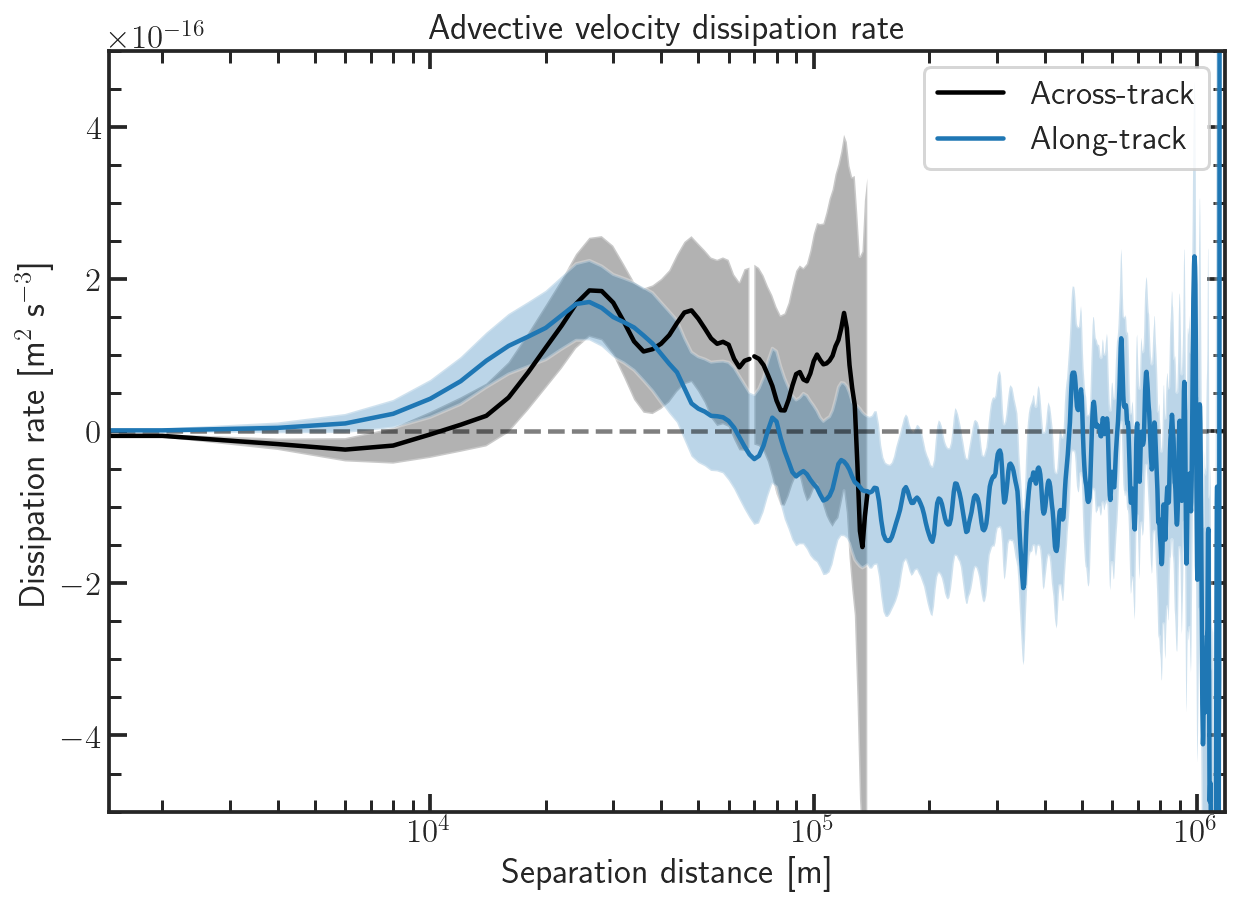

In [14]:
fig, (ax1) = plt.subplots(figsize=(10, 7))

flux_sf_figures.SF_bootstrap_plot(0.5 * boot_SF_vz_mean_adv, 0.5 * boot_SF_vm_mean_adv, 
                                  yd_uneven_adv, xd_uneven_adv, 
                                  bootz0=0.5*boot_SF_vz_conf_adv[0], bootz1=0.5*boot_SF_vz_conf_adv[1],
                                  bootm0=0.5*boot_SF_vm_conf_adv[0], bootm1=0.5*boot_SF_vm_conf_adv[1],
                                  title='Advective velocity SFs', label1='Across-track',label2='Along-track',ax=ax1)

ax1.tick_params(direction="in", which="both")
ax1.xaxis.get_ticklocs(minor=True)
ax1.set_ylim(-0.5e-15,0.5e-15)
ax1.minorticks_on()
ax1.set_title('Advective velocity dissipation rate')

Text(0.5, 1.0, 'Traditional velocity dissipation rate')

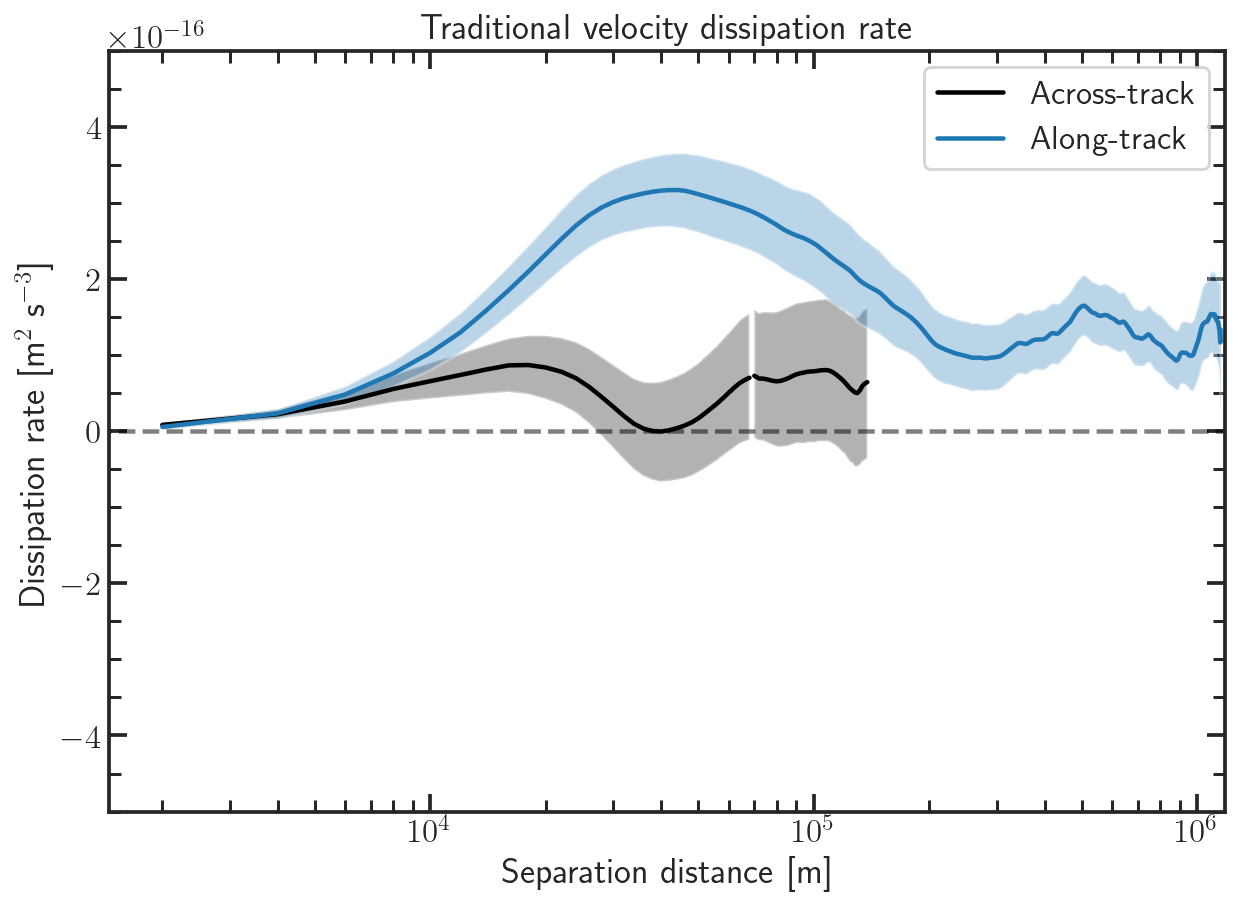

In [15]:
fig, (ax1) = plt.subplots(figsize=(10, 7))

flux_sf_figures.SF_bootstrap_plot((2/3) * boot_SF_vz_mean_trad / yd_uneven_trad, (2/3) * boot_SF_vm_mean_trad / xd_uneven_trad, 
                                  yd_uneven_trad, xd_uneven_trad, 
                                  bootz0=(2/3) * boot_SF_vz_conf_trad[0] / yd_uneven_trad, bootz1=(2/3) * boot_SF_vz_conf_trad[1] / yd_uneven_trad,
                                  bootm0=(2/3) * boot_SF_vm_conf_trad[0] / xd_uneven_trad, bootm1=(2/3) * boot_SF_vm_conf_trad[1] / xd_uneven_trad,
                                  title='Third-order velocity SFs', label1='Across-track',label2='Along-track',ax=ax1)

ax1.tick_params(direction="in", which="both")
ax1.xaxis.get_ticklocs(minor=True)
ax1.set_ylim(-0.5e-15,0.5e-15)
ax1.minorticks_on()
ax1.set_title('Traditional velocity dissipation rate')

In [97]:
sf_m_tmp_list = {}
v_tmp = [(processed_ds_trad[i].v.values * u.cm / u.s).si.value for i in range(1,594)]

for j in range(1,594):
    sf_m_tmp = []

    for i in range(1,594):
        dm_tmp = np.pad(v_tmp[j], ((0,i),(0,0)),mode="constant",constant_values=np.nan,)[i:,:] - v_tmp[j]
        dm3_tmp = dm_tmp**3
        sf_m_tmp.append(np.nanmean(dm3_tmp))
    sf_m_tmp_list[str(j)] = np.array(sf_m_tmp)

IndexError: list index out of range

In [98]:
sf_m_tmp_mean = np.mean(np.array(list(sf_m_tmp_list.values())),axis=0)

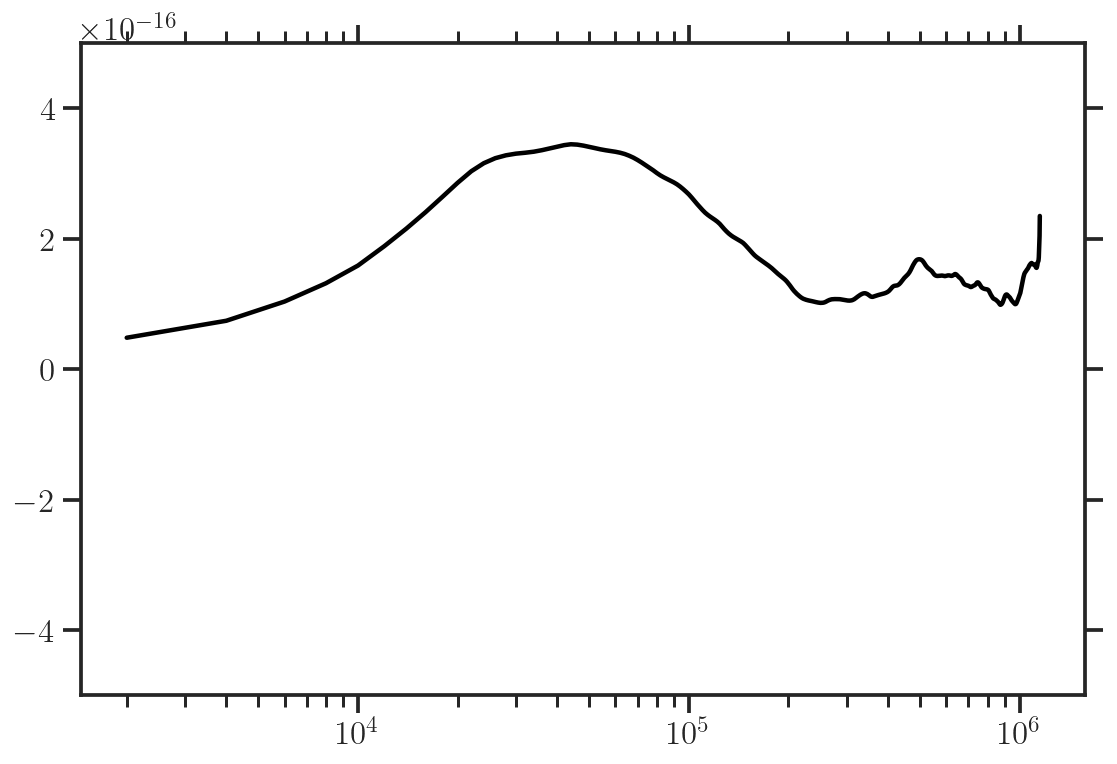

In [99]:
# for i in sf_m_tmp_list:
#     plt.semilogx(xd_uneven_trad, (2/3) * sf_m_tmp_list[i] / xd_uneven_trad,c='tab:blue',alpha=0.5)
plt.semilogx(xd_uneven_trad, (2/3) * sf_m_tmp_mean / xd_uneven_trad,c='k')
plt.ylim(-0.5e-15,0.5e-15)
plt.show()

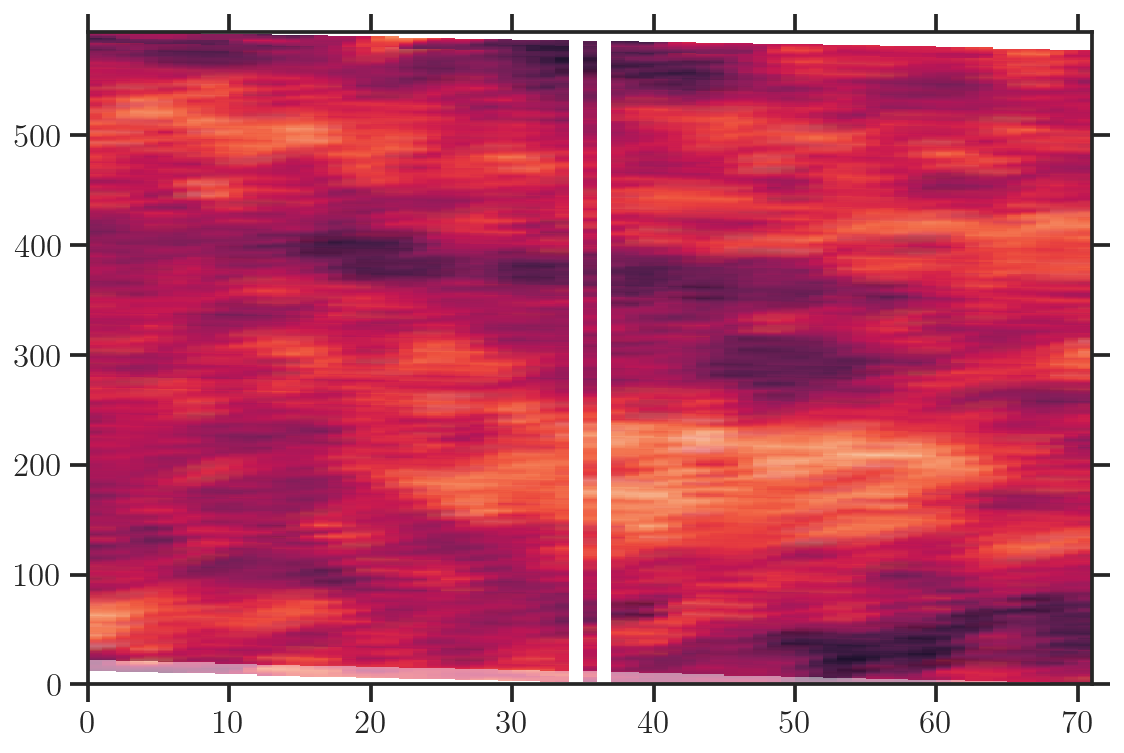

In [96]:
plt.pcolormesh(processed_ds_trad[0].v)
plt.pcolormesh(np.pad(processed_ds_trad[0].v, ((0,10),(0,0)),mode="constant",constant_values=np.nan,)[10:,:],alpha=0.5)